## Head

In [1]:
import os
import sys
sys.path.append('/Users/vavbrs/Documents/karpov/lessons/L5_app_live/uplift-campaign/')

import pandas as pd
import numpy as np
import dask.dataframe as dd
import pickle
import json
import sklearn.base as skbase
import sklearn.pipeline as skpipe
import datetime
import matplotlib.pyplot as plt

In [2]:
import upcampaign.datalib as datalib
import upcampaign.datalib.connection as connection
import upcampaign.datalib.features.compute as fcompute
# import upcampaign.model_utils as mu

In [3]:
import lightgbm as lgb
import causalml.metrics as cmetrics
import causalml.inference.meta.rlearner as rlearner

from sklearn.model_selection import train_test_split

## Load'n'cook

### engine

In [4]:
data_root_path = '../../lessons/L4_feature_store/data/light/'

receipts = dd.read_parquet(os.path.join(data_root_path, 'receipts.parquet'))
campaigns = dd.read_csv(os.path.join(data_root_path, 'campaigns.csv'))
client_profile = dd.read_csv(os.path.join(data_root_path, 'client_profile.csv'))
purchases = dd.read_parquet(os.path.join(data_root_path, 'purchases.parquet/'))
products = dd.read_csv(os.path.join(data_root_path, 'products.csv'))

In [5]:
engine = connection.Engine(tables={
    'receipts': receipts,
    'campaigns': campaigns,
    'client_profile': client_profile,
    'purchases': purchases,
    'products': products
})

### extract & transform features

In [6]:
MARGIN_RATE = 0.2
POINT_TO_RUB = 0.1
COMMUNICATION_COST = 1.5

data_config = {
    'extract': [
        {
            'name': 'receipts_basic',
            'args': {'delta': 60, 'date_to': datetime.date(2019, 3, 19)}
        },
        {
            'name': 'receipts_basic',
            'args': {'delta': 15, 'date_to': datetime.date(2019, 3, 19)}
        },
        {
            'name': 'age_gender',
            'args': {}
        },
        {
            'name': 'unique_categories',
            'args': {
                'col_category': 'level_3',
                'delta': 60,
                'date_to': datetime.date(2019, 3, 19)
            }
        },
        {
            'name': 'target_from_campaigns',
            'args': {'date_to': datetime.date(2019, 3, 21)}
        }
    ],
    'transform': [
        {
            'name': 'expression',
            'args': {
                'expression': f"{{d}}['target_purchases_sum'] * {MARGIN_RATE} - {{d}}['target_campaign_points_spent'] * {POINT_TO_RUB} - {{d}}['treatment_flg'] * {COMMUNICATION_COST}",
                'col_result': 'target_profit'
            }
        },
        {
            'name': 'expression',
            'args': {
                'expression': "{d}['purchase_sum_sum__60d'] / {d}['unique_level_3__60d']",
                'col_result': 'purchase_sum_per_category_level_3__60d'
            }
        },
        {
            'name': 'one_hot_encode',
            'args': {
                'cols': ['gender']
            }
        }
    ]
}

In [7]:
raw_data = fcompute.extract_features(engine, config=data_config['extract'])


You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, meta=(None, 'float64'))


You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, meta=('transaction_datetime_max', 'float64'))


You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silen

In [9]:
raw_data = raw_data.compute()

In [12]:
raw_data.shape

(500000, 44)

In [13]:
raw_data.head()

,client_id,transaction_id_count__60d,purchase_sum_sum__60d,purchase_sum_max__60d,purchase_sum_min__60d,purchase_sum_mean__60d,regular_points_spent_sum__60d,regular_points_spent_max__60d,express_points_spent_sum__60d,express_points_spent_max__60d,...,express_points_spent_flag_sum__15d,mean_time_interval__15d,time_since_last__15d,age,gender,unique_level_3__60d,treatment_flg,target_purchases_sum,target_purchases_count,target_campaign_points_spent
0,0,2,1222.00,803.0,419.0,611.000000,0.0,0.0,0.0,0.0,...,0.0,6.201204,4.373762,45,U,14.0,0,909.0,1,0.0
1,1,18,5366.00,561.0,58.0,298.111111,0.0,0.0,0.0,0.0,...,0.0,5.969728,1.562766,72,F,31.0,1,791.0,2,-0.0
2,2,5,2569.00,1204.0,113.0,513.800000,0.0,0.0,0.0,0.0,...,0.0,NaN,6.563669,68,F,12.0,0,0.0,0,0.0
3,3,2,1446.00,739.0,707.0,723.000000,0.0,0.0,0.0,0.0,...,0.0,NaN,9.679317,48,U,15.0,1,654.0,1,-0.0
4,4,10,5820.37,1017.0,154.0,582.037000,0.0,0.0,0.0,0.0,...,0.0,NaN,2.596285,60,F,24.0,1,0.0,0,-0.0


In [23]:
transform_pipeline = fcompute.create_pipeline(data_config['transform'])

In [24]:
data = transform_pipeline.fit_transform(raw_data.copy())

In [25]:
data.head(30)

,client_id,transaction_id_count__60d,purchase_sum_sum__60d,purchase_sum_max__60d,purchase_sum_min__60d,purchase_sum_mean__60d,regular_points_spent_sum__60d,regular_points_spent_max__60d,express_points_spent_sum__60d,express_points_spent_max__60d,...,unique_level_3__60d,treatment_flg,target_purchases_sum,target_purchases_count,target_campaign_points_spent,target_profit,purchase_sum_per_category_level_3__60d,ohe__gender__F,ohe__gender__M,ohe__gender__U
0,0,2,1222.00,803.00,419.00,611.000000,0.0,0.0,0.0,0.0,...,14.0,0,909.00,1,0.0,181.800,87.285714,0.0,0.0,1.0
1,1,18,5366.00,561.00,58.00,298.111111,0.0,0.0,0.0,0.0,...,31.0,1,791.00,2,-0.0,156.700,173.096774,1.0,0.0,0.0
2,2,5,2569.00,1204.00,113.00,513.800000,0.0,0.0,0.0,0.0,...,12.0,0,0.00,0,0.0,0.000,214.083333,1.0,0.0,0.0
3,3,2,1446.00,739.00,707.00,723.000000,0.0,0.0,0.0,0.0,...,15.0,1,654.00,1,-0.0,129.300,96.400000,0.0,0.0,1.0
4,4,10,5820.37,1017.00,154.00,582.037000,0.0,0.0,0.0,0.0,...,24.0,1,0.00,0,-0.0,-1.500,242.515417,1.0,0.0,0.0
5,5,3,1800.84,1043.84,377.00,600.280000,0.0,0.0,0.0,0.0,...,16.0,1,374.76,1,-0.0,73.452,112.552500,0.0,0.0,1.0
6,6,15,3718.55,555.95,25.99,247.903333,-127.0,0.0,0.0,0.0,...,26.0,0,155.97,1,0.0,31.194,143.021154,1.0,0.0,0.0
7,7,21,9166.66,1454.00,124.12,436.507619,-92.0,0.0,0.0,0.0,...,34.0,0,1036.00,1,0.0,207.200,269.607647,0.0,0.0,1.0
8,8,19,5175.83,587.17,46.00,272.412105,0.0,0.0,0.0,0.0,...,27.0,1,784.67,3,300.0,125.434,191.697407,0.0,0.0,1.0
9,9,4,3270.63,1965.00,247.00,817.657500,0.0,0.0,0.0,0.0,...,17.0,1,1455.48,4,300.0,259.596,192.390000,0.0,1.0,0.0


### splits

In [32]:
fit_index, val_index = train_test_split(data.index, test_size=0.5, random_state=165)

### column sets

In [26]:
data.columns

Index(['client_id', 'transaction_id_count__60d', 'purchase_sum_sum__60d',
       'purchase_sum_max__60d', 'purchase_sum_min__60d',
       'purchase_sum_mean__60d', 'regular_points_spent_sum__60d',
       'regular_points_spent_max__60d', 'express_points_spent_sum__60d',
       'express_points_spent_max__60d', 'transaction_datetime_min__60d',
       'transaction_datetime_max__60d', 'trn_sum_from_red_sum__60d',
       'trn_sum_from_red_max__60d', 'trn_sum_from_red_mean__60d',
       'points_spent_flag_sum__60d', 'express_points_spent_flag_sum__60d',
       'mean_time_interval__60d', 'time_since_last__60d',
       'transaction_id_count__15d', 'purchase_sum_sum__15d',
       'purchase_sum_max__15d', 'purchase_sum_min__15d',
       'purchase_sum_mean__15d', 'regular_points_spent_sum__15d',
       'regular_points_spent_max__15d', 'express_points_spent_sum__15d',
       'express_points_spent_max__15d', 'transaction_datetime_min__15d',
       'transaction_datetime_max__15d', 'trn_sum_from_red_s

In [27]:
cols_features_n1 = [
    'transaction_id_count__60d',
    'purchase_sum_sum__60d',
    'purchase_sum_max__60d',
    'purchase_sum_min__60d',
    'purchase_sum_mean__60d',
    'regular_points_spent_sum__60d',
    'regular_points_spent_max__60d',
    'express_points_spent_sum__60d',
    'express_points_spent_max__60d',
    'trn_sum_from_red_sum__60d',
    'trn_sum_from_red_max__60d',
    'trn_sum_from_red_mean__60d',
    'points_spent_flag_sum__60d',
    'express_points_spent_flag_sum__60d',
    'mean_time_interval__60d',
    'time_since_last__60d',
    'purchase_sum_per_category_level_3__60d',
    'age',
    'ohe__gender__F',
    'ohe__gender__M'
]

## Model

#### build model

In [28]:
col_target = 'target_profit'
col_treatment = 'treatment_flg'

In [29]:
cols_features = cols_features_n1

In [30]:
model_n1 = rlearner.BaseRRegressor(
    learner=lgb.LGBMRegressor(),
    control_name=0,
    n_fold=4,
    random_state=165
)

In [33]:
_p_score_const = data.loc[fit_index, col_treatment].value_counts(normalize=True).loc[1]
_p_scores = pd.Series(data=_p_score_const, index=fit_index)
model_n1.fit(
    X=data.loc[fit_index, cols_features].values,
    treatment=data.loc[fit_index, col_treatment].values,
    y=data.loc[fit_index, col_target].values,
    p=_p_scores
)

#### evaluate model

In [34]:
_eval_data = data.loc[val_index, cols_features + [col_treatment, col_target]]
_eval_data['score'] = model_n1.predict(_eval_data[cols_features])
_eval_data = _eval_data[['score', col_treatment, col_target]]

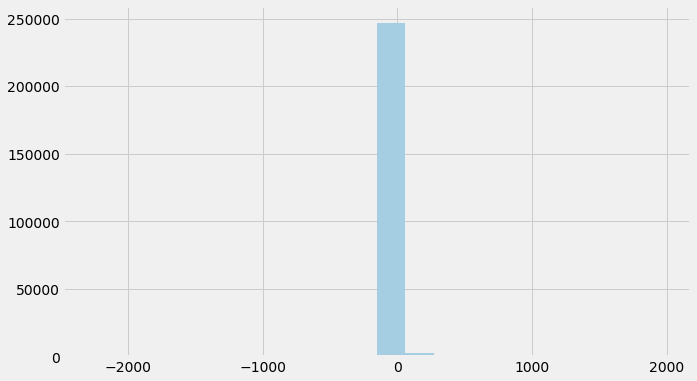

In [35]:
plt.figure(figsize=(10, 6))
plt.hist(_eval_data['score'], bins=20)
plt.show()

In [36]:
np.percentile(_eval_data['score'], 5)

-9.46201540358517

In [37]:
np.percentile(_eval_data['score'], 95)

5.797288346357485

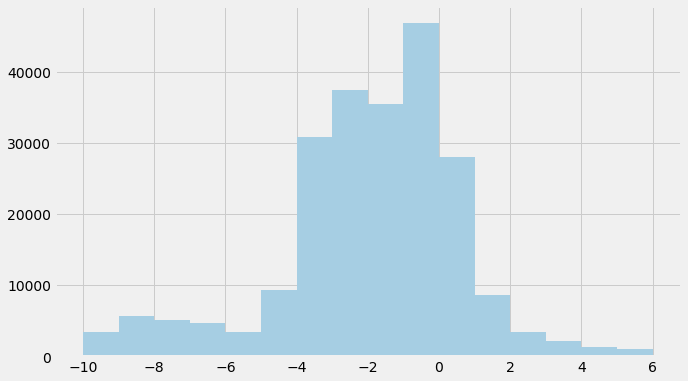

In [38]:
plt.figure(figsize=(10, 6))
plt.hist(_eval_data['score'], range=(-10.0, 6.0), bins=16)
plt.show()

In [39]:
_eval_data['score'].describe()

count    250000.000000
mean         -0.989863
std          33.647257
min       -2265.973911
25%          -3.281552
50%          -1.705388
75%          -0.171674
max        1958.750116
Name: score, dtype: float64

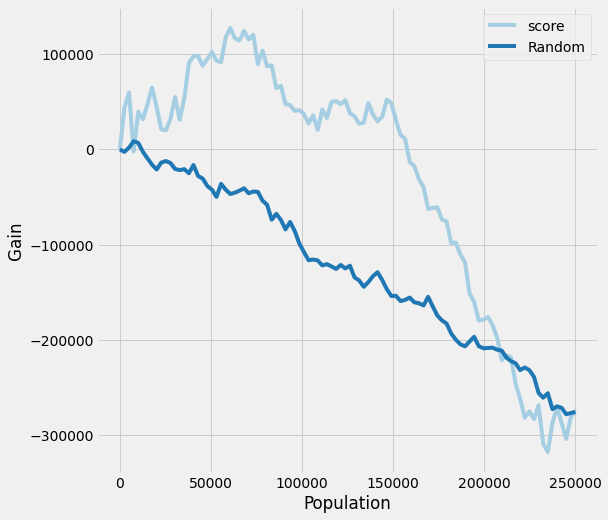

In [40]:
cmetrics.plot_gain(
    _eval_data,
    treatment_col=col_treatment,
    outcome_col=col_target,
)

Порог, по которому будем отсекать клиентов в кампании:

In [43]:
np.percentile(_eval_data['score'], 75)

-0.17167353077748457

## Save for serving

In [44]:
model_n1_keeper = mu.ModelKeeper(model_n1, column_set=cols_features)

In [45]:
model_n1_keeper.dump('artifacts/n1_exp300_model.pickle')

In [46]:
data_config

{'extract': [{'name': 'receipts_basic',
   'args': {'delta': 60, 'date_to': datetime.date(2019, 3, 19)}},
  {'name': 'receipts_basic',
   'args': {'delta': 15, 'date_to': datetime.date(2019, 3, 19)}},
  {'name': 'age_gender', 'args': {}},
  {'name': 'unique_categories',
   'args': {'col_category': 'level_3',
    'delta': 60,
    'date_to': datetime.date(2019, 3, 19)}},
  {'name': 'target_from_campaigns',
   'args': {'date_to': datetime.date(2019, 3, 21)}}],
 'transform': [{'name': 'expression',
   'args': {'expression': "{d}['target_purchases_sum'] * 0.2 - {d}['target_campaign_points_spent'] * 0.1 - {d}['treatment_flg'] * 1.5",
    'col_result': 'target_profit'}},
  {'name': 'expression',
   'args': {'expression': "{d}['purchase_sum_sum__60d'] / {d}['unique_level_3__60d']",
    'col_result': 'purchase_sum_per_category_level_3__60d'}},
  {'name': 'one_hot_encode', 'args': {'cols': ['gender']}}]}

Нужно
* Убрать калкеры и трансформации, относящиеся к расчету таргета
* Убрать date_to из конфигурации

In [47]:
serving_extract_config = [
    {
        'name': 'receipts_basic',
        'args': {'delta': 60}
    },
    {
        'name': 'receipts_basic',
        'args': {'delta': 15}
    },
    {
        'name': 'age_gender',
        'args': {}
    },
    {
        'name': 'unique_categories',
        'args': {
            'col_category': 'level_3',
            'delta': 60
        }
    }
]

In [49]:
with open('artifacts/n1_serving_extract_config.json', 'w') as file:
    json.dump(serving_extract_config, file)

In [50]:
transform_pipeline.steps

[('stage_0',
  FunctionalTransformer(function=functools.partial(<function expression_transformer at 0x140f8cc10>, expression="{d}['target_purchases_sum'] * 0.2 - {d}['target_campaign_points_spent'] * 0.1 - {d}['treatment_flg'] * 1.5", col_result='target_profit'))),
 ('stage_1',
  FunctionalTransformer(function=functools.partial(<function expression_transformer at 0x140f8cc10>, expression="{d}['purchase_sum_sum__60d'] / {d}['unique_level_3__60d']", col_result='purchase_sum_per_category_level_3__60d'))),
 ('stage_2', OneHotEncoder(cols=['gender']))]

In [51]:
serving_transform_pipeline = skpipe.Pipeline(transform_pipeline.steps[1: ])

In [52]:
with open('artifacts//n1_serving_transform_pipeline.pickle', 'wb') as file:
    pickle.dump(serving_transform_pipeline, file)

В результате построения модели мы сохранили
* Саму модель.
* Колонки, необходимые для ее расчета.
* Конфигурацию калкеров для извлечения признаков из БД.
* Pipeline преобразования признаков.

## backups

In [11]:
raw_data.to_parquet('junk/raw_data.parquet')

In [68]:
data.to_parquet('junk/data.parquet')